# Data

Load the dataset: recyclable, compost, landfill, (hazardous).

In [ ]:
from google.colab import drive

drive.mount('drive')

Mounted at drive


In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [ ]:
files = zf.ZipFile("/content/drive/MyDrive/Colab Notebooks/dataset-resized.zip", 'r')
files.extractall()
files.close()

In [ ]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['trash', 'cardboard', 'paper', 'plastic', 'metal', '.DS_Store', 'glass']

In [ ]:

## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [ ]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [ ]:
# get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

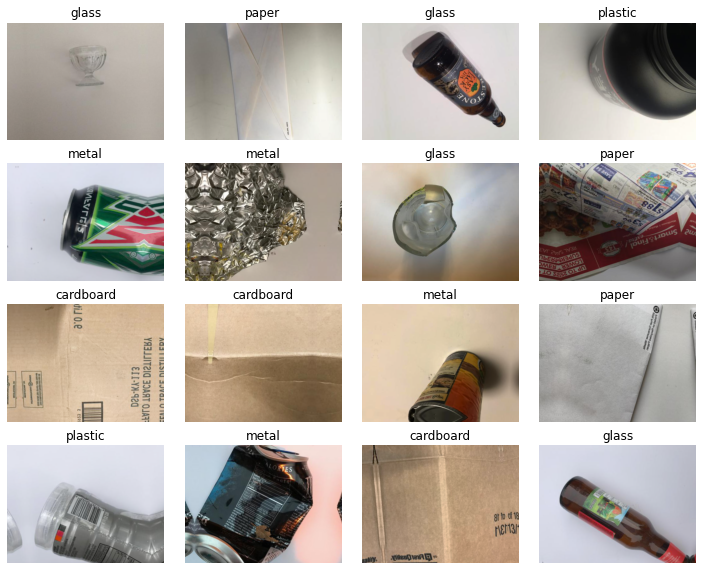

In [ ]:
data.classes
data.show_batch(rows = 4, figsize = (10, 8))

#Train the model

In [ ]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)
learn.model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


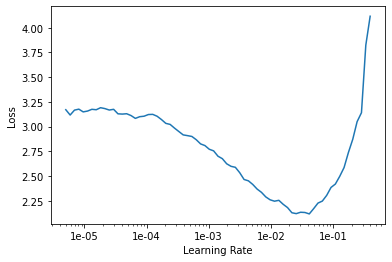

In [ ]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)

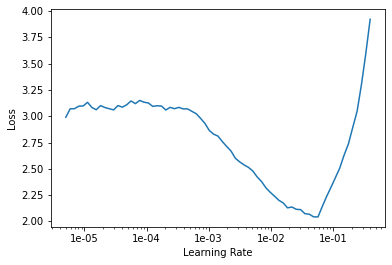

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.626014,0.686063,0.263492,00:34
1,1.047921,0.522045,0.180952,00:34
2,0.860900,0.596521,0.196825,00:34
3,0.811664,0.637203,0.207937,00:34
4,0.817266,0.822750,0.249206,00:34
5,0.821830,0.644936,0.201587,00:34
6,0.754324,0.486805,0.160317,00:34
7,0.654181,0.605265,0.179365,00:34
8,0.660691,0.522956,0.168254,00:34
9,0.672274,0.332682,0.112698,00:34


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

# Test

In [ ]:
preds = learn.get_preds(ds_type=DatasetType.Test)

Run the block to test one image.

In [46]:
# test_model = torch.load("model.pth.tar")
learn.export()
path = Path(os.getcwd())/"data"
print(path)
learn = load_learner(path)
test_img_path = 'data/test/cardboard101.jpg'
im = open_image(test_img_path)
pred_class,pred_idx,outputs = learn.predict(im)
print (pred_class)

/content/data
cardboard


In [ ]:
import cv2
from PIL import Image
import numpy as np
def test_one(model, image):
    model.eval()
    output = model(image)
    return output
torch.save(learn.model, "model.pth.tar")
img = torch.from_numpy(np.asarray(Image.open(name)))
test_one(test_model, img)